In [1]:
# Import all the libraries needed
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import os
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [2]:
# Define the transformation/augmentation for the data
array_transforms = {
    'train':
    transforms.Compose([
#         transforms.RandomRotation(degrees=180),
#         transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
    'val':
    transforms.Compose([
#         transforms.RandomRotation(degrees=180),
#         transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
    'test':
    transforms.Compose([
#         transforms.RandomRotation(degrees=180),
#         transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
}




# Tell the dataloader where to search and where to put the arrays
traindir = 'Data/traindir'
train_channels = [f'{traindir}/r_data', f'{traindir}/g_data']

valdir = 'Data/valdir'
val_channels = [f'{valdir}/r_data', f'{valdir}/g_data']

testdir = 'Data/testdir'
test_channels = [f'{testdir}/r_data', f'{testdir}/g_data']

train_inputs = []
train_labels = []

val_inputs = []
val_labels = []

test_inputs = []
test_labels = []




# Load the saved .npy arrays from the preprocessing.py file into the above arrays,
# split up the red and green channel again so that the axes match in size
def load_npy_arrays(phase):
    
    if phase == "train":
        phase_channels = train_channels
        phase_inputs = train_inputs
        phasedir = traindir
        phase_labels = train_labels
    
    elif phase == "val":
        phase_channels = val_channels
        phase_inputs = val_inputs
        phasedir = valdir
        phase_labels = val_labels
    
    elif phase == "test":
        phase_channels = test_channels
        phase_inputs = test_inputs
        phasedir = testdir
        phase_labels = test_labels
    
    else:
        print('Valueerror: please pass one of the three accepted strings("train", "val", "test")')

    for channel in phase_channels:
        path_to_channel = channel
        for file in sorted(os.listdir(channel)):
            filename = file
            if filename.endswith('.npy'):
                loaded_array = np.load(f'{path_to_channel}/{filename}')
                phase_inputs.append(loaded_array)
                continue
            else:
                continue
                
    labelfolder = f'{phasedir}/labels'
    for file in sorted(os.listdir(labelfolder)):
        filename = file
        if filename.endswith('.npy'):
            loaded_array = np.load(f'{labelfolder}/{filename}')
            phase_labels.append(loaded_array)
            continue
        else:
            continue
    print(np.shape(phase_labels))

load_npy_arrays("train")
load_npy_arrays("val")
load_npy_arrays("test")

train_inputs = np.asarray(train_inputs)
train_inputs = np.split(train_inputs, 2, axis=0)
train_inputs = np.asarray(train_inputs).transpose(1,0,2,3)
print(np.shape(train_inputs))

val_inputs = np.asarray(val_inputs)
val_inputs = np.split(val_inputs, 2, axis=0)
val_inputs = np.asarray(val_inputs).transpose(1,0,2,3)
print(np.shape(val_inputs))

test_inputs = np.asarray(test_inputs)
test_inputs = np.split(test_inputs, 2, axis=0)
test_inputs = np.asarray(test_inputs).transpose(1,0,2,3)
print(np.shape(test_inputs))

train_labels = np.asarray(train_labels)
val_labels = np.asarray(val_labels)
test_labels = np.asarray(test_labels)


# Define our own dataset creator because we want to load numpy arrays,
# but still be able to apply transformations as if it were images
class CreateDataset(Dataset):
    def __init__(self, inputs, labels, transform=None):
        self.inputs = torch.FloatTensor(inputs)
        self.labels = torch.FloatTensor(labels)
        self.transform = transform

    def __getitem__(self, index):
        x = self.inputs[index]
        y = self.labels[index]

        if self.transform:
            x = Image.fromarray(self.inputs[index].numpy().astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
            
            y = Image.fromarray(self.labels[index].numpy().astype(np.uint8))
            y = self.transform(y)

        return x, y

    def __len__(self):
        return len(self.inputs)

    
# Get the data, transform it
data = {
   'train':
   CreateDataset(train_inputs, train_labels, transform = array_transforms['train']),
   'val':
   CreateDataset(val_inputs, val_labels, transform = array_transforms['val']),
    'test':
   CreateDataset(test_inputs, test_labels, transform = array_transforms['test']),
}


batch_size = 8
print('Sum of all labels in a batch: ' ,batch_size*np.sum(train_labels[0]))

# Load Data in batches, shuffled
dataloaders = {
   'train': DataLoader(data['train'], batch_size=batch_size, shuffle=False, drop_last=True),
   'val': DataLoader(data['val'], batch_size=batch_size, shuffle=False, drop_last=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=False, drop_last=True),
}

(1546, 100, 100)
(284, 100, 100)
(330, 100, 100)
(1546, 2, 100, 100)
(284, 2, 100, 100)
(330, 2, 100, 100)
Sum of all labels in a batch:  20764.67080316791


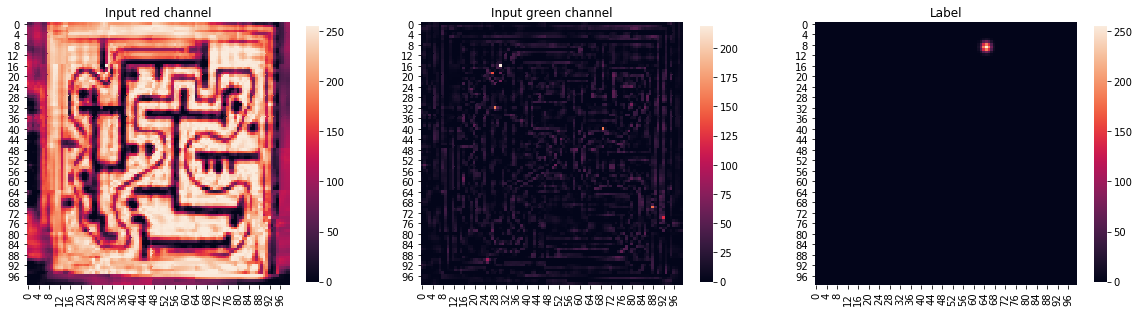

In [3]:
# Visualize the input of the CNN
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(3, 3, 1)
ax1.set_title('Input red channel')
ax2 = fig.add_subplot(3, 3, 2)
ax2.set_title('Input green channel')
ax3 = fig.add_subplot(3, 3, 3)
ax3.set_title('Label')

sns.heatmap(train_inputs[0][0], ax=ax1, square=True, cbar_kws={'shrink': .8})
sns.heatmap(train_inputs[0][1], ax=ax2, square=True, cbar_kws={'shrink': .8})
sns.heatmap(train_labels[0], ax=ax3, square=True, cbar_kws={'shrink': .8})
plt.show()

In [4]:
# Load in pretrained VGG16 net, extract the FCN part, delete pooling layers,
# modify first layer to recieve 2 channels, the last one to output depth 1

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2,16,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True))
    
        self.layer2 = nn.Sequential( 
            nn.Conv2d(16,32,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(64,1,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True))

    def forward(self,x):
        x = self.layer1(x)  
        x = self.layer2(x)  
        x = self.layer3(x)  
        x = self.layer4(x)  
        return x

In [5]:
# Check if GPU is available and move the model over to GPU
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
    gpu_name = torch.cuda.get_device_name()
    print(f"Running on your {gpu_name} (GPU)")
else:
    device = torch.device("cpu")
    print("Running on your CPU")

net = CNN().to(device)

Running on your GeForce GTX 970M (GPU)


Epoch 1/10
----------


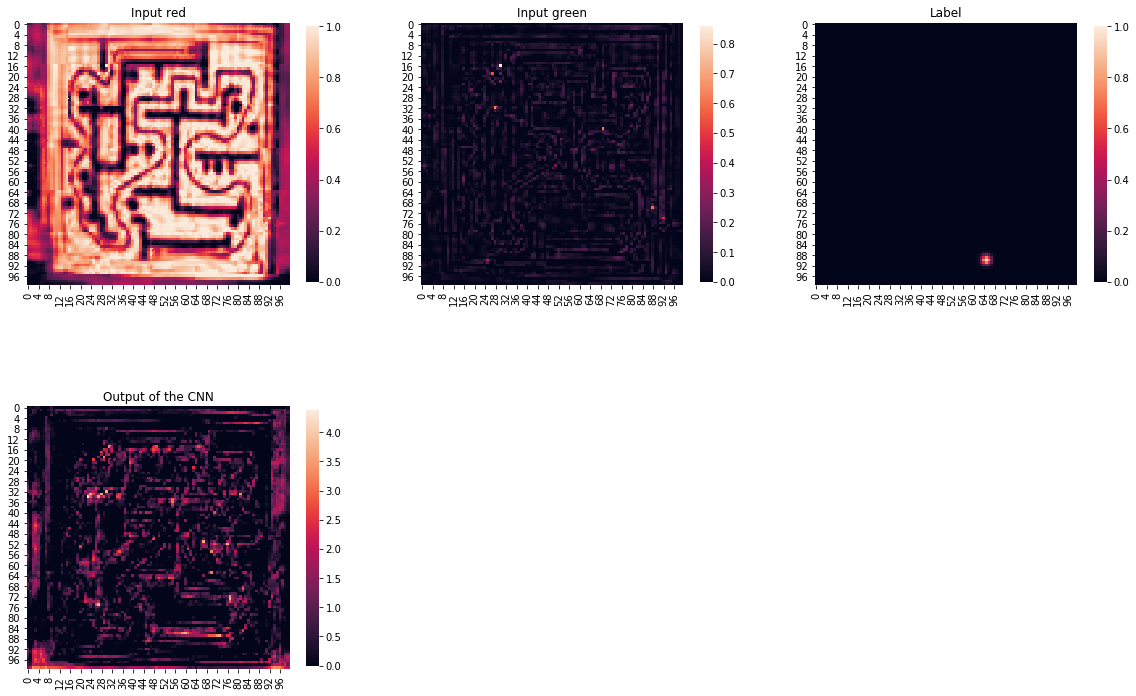

Training Loss: 31408.1328


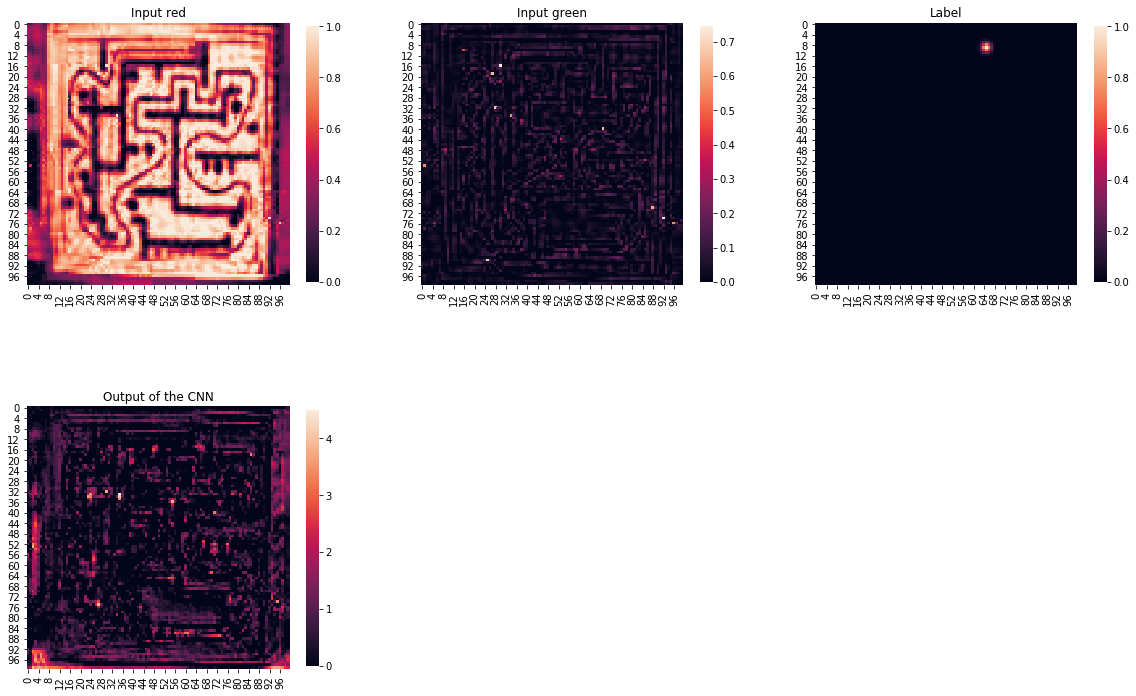

Training Loss: 30487.1719


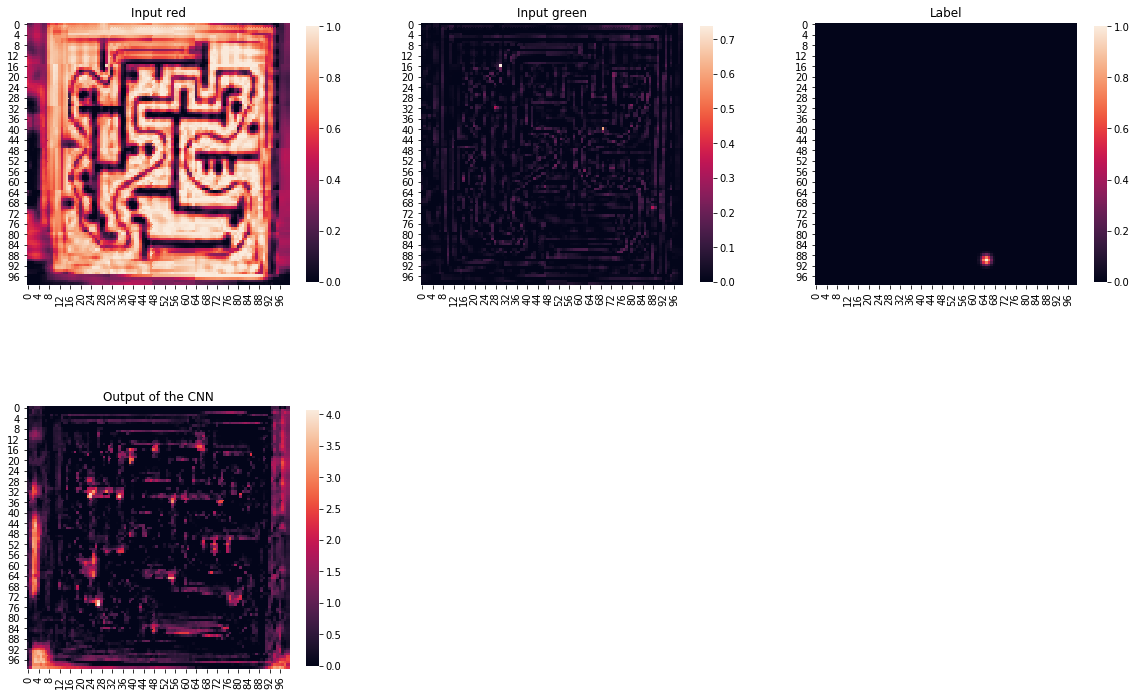

Training Loss: 29185.2109


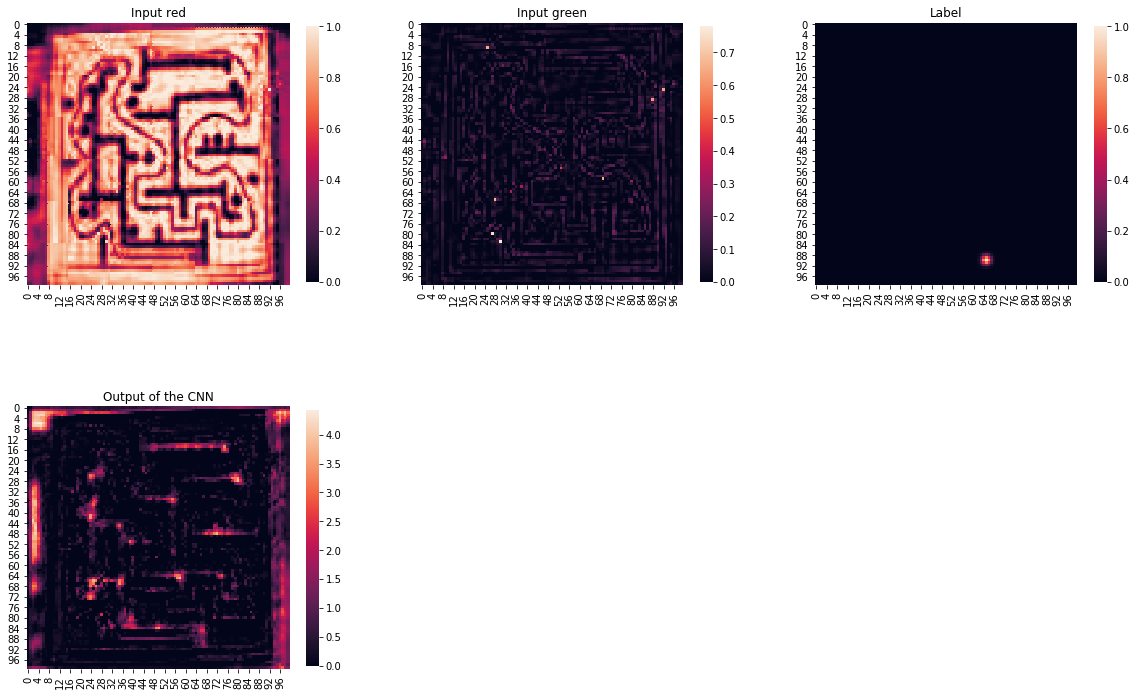

Training Loss: 27328.3652


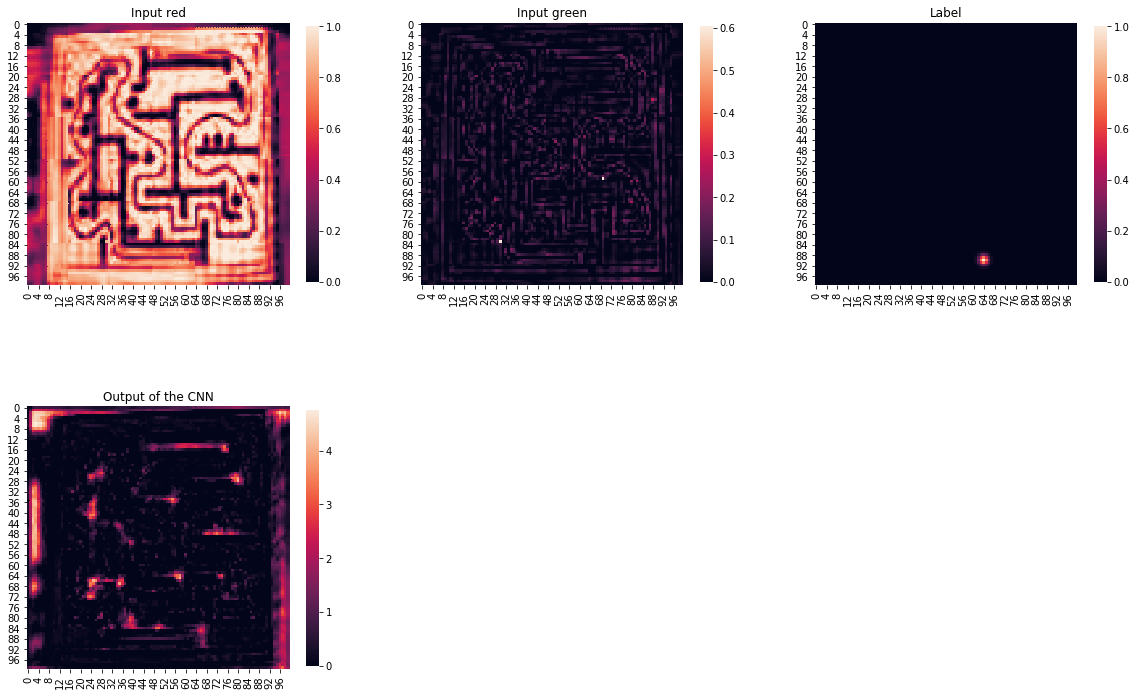

Training Loss: 25342.3398


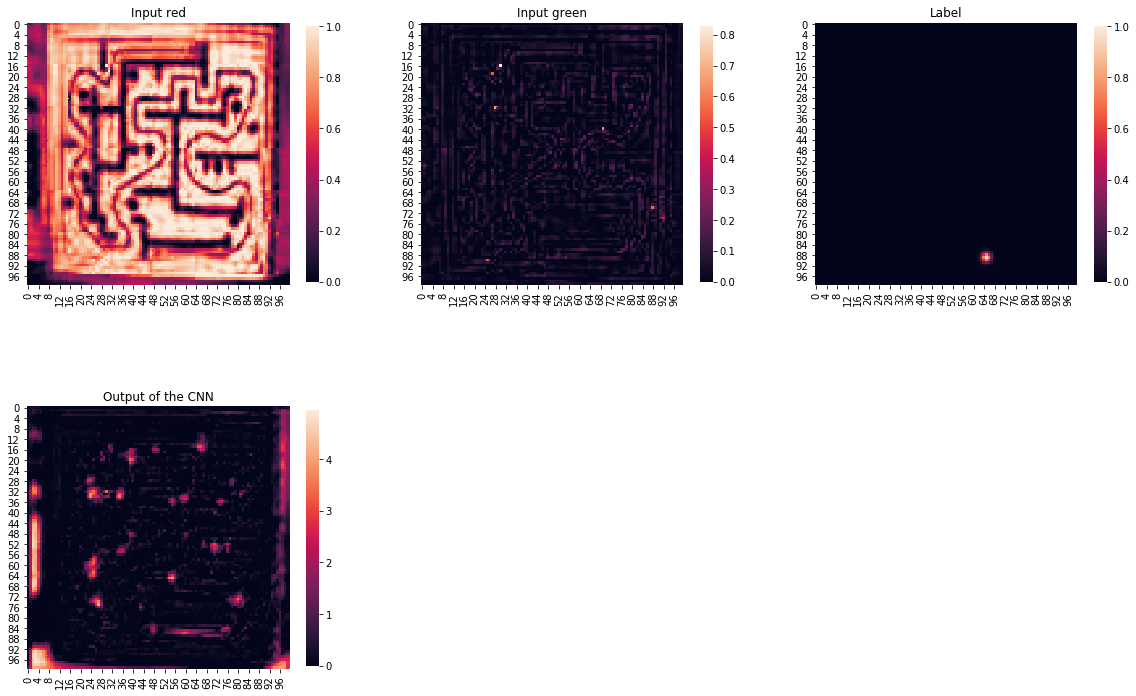

Training Loss: 24608.2461


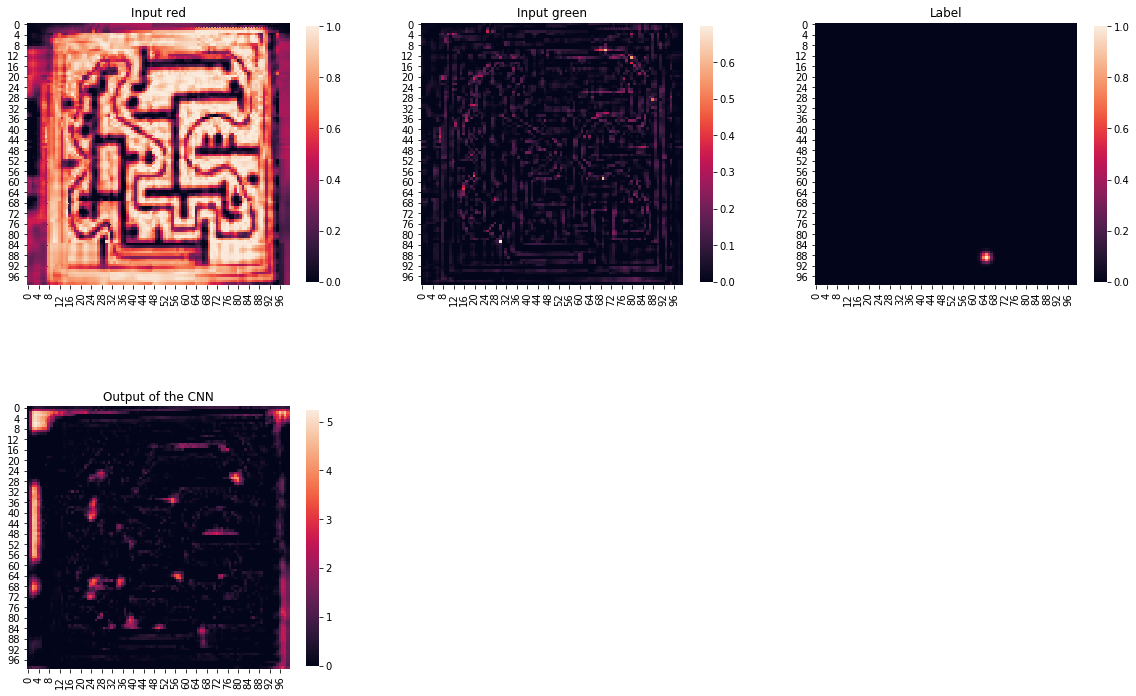

Training Loss: 24035.3926


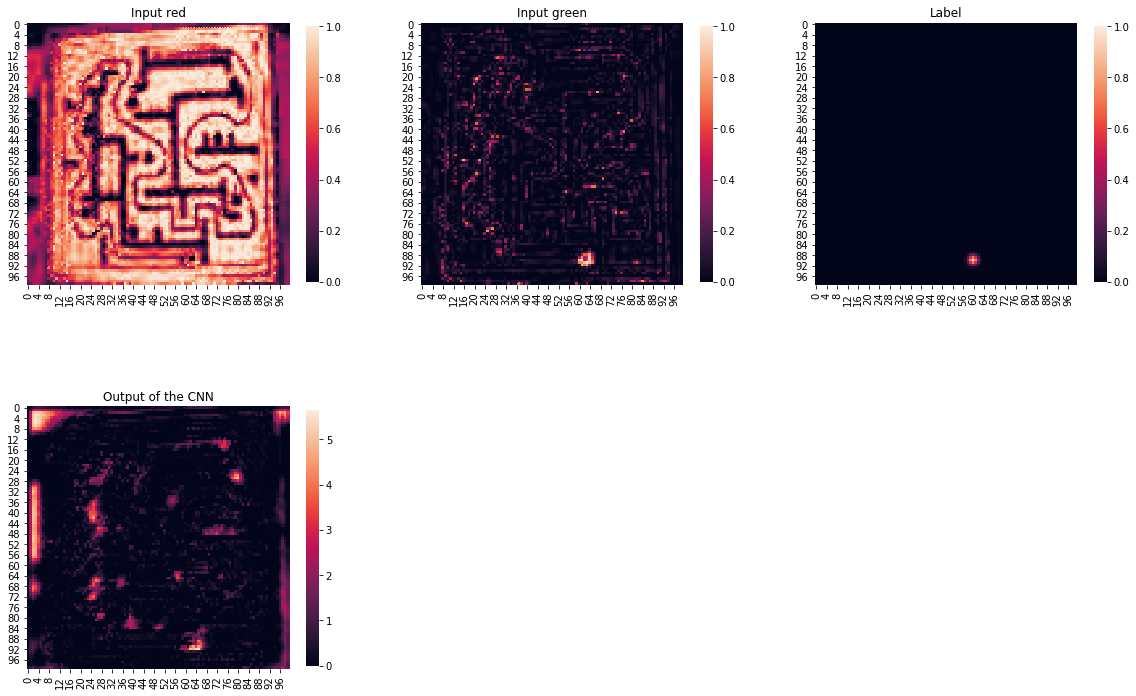

Training Loss: 22401.5918


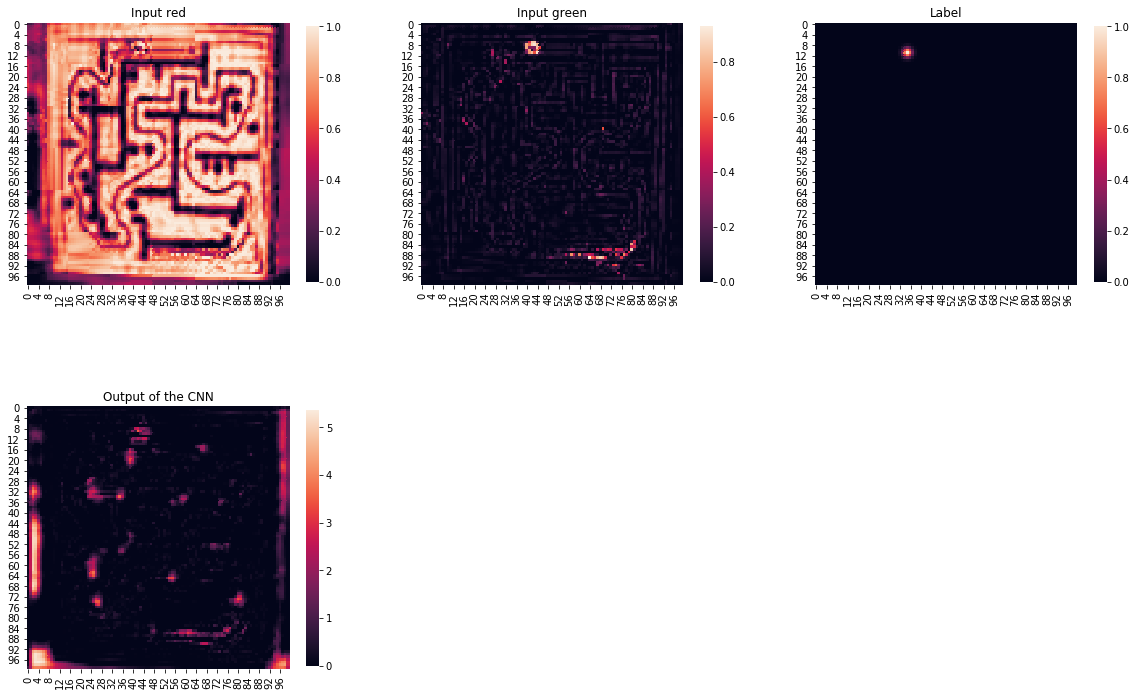

Training Loss: 21755.3379


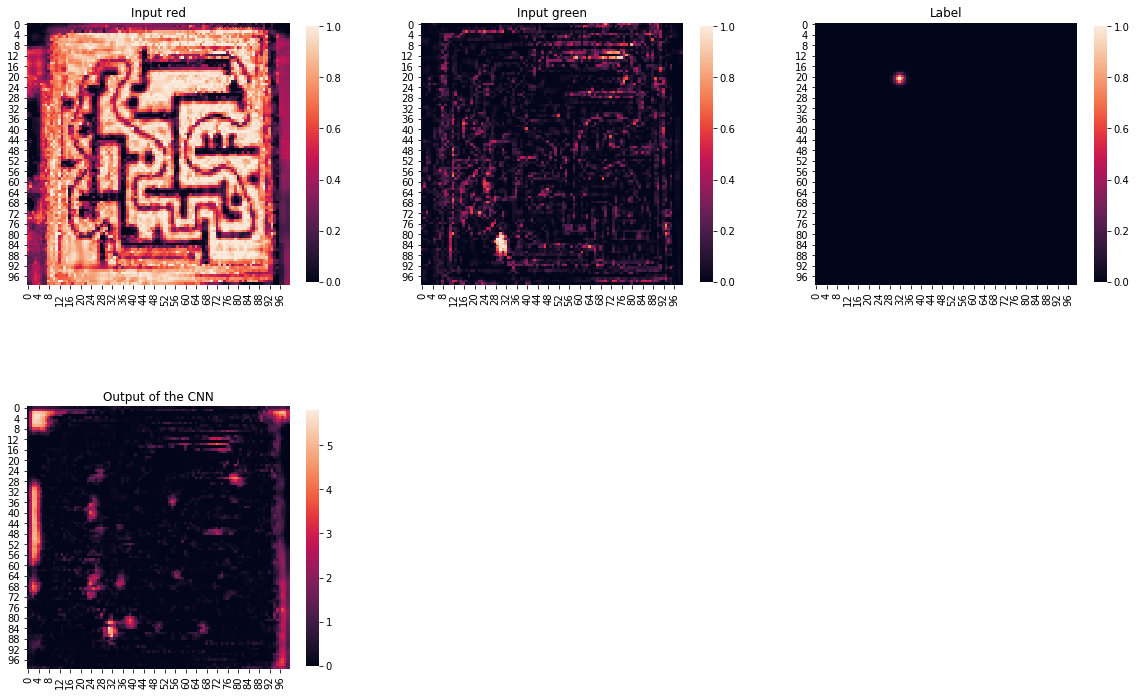

Training Loss: 20710.2715


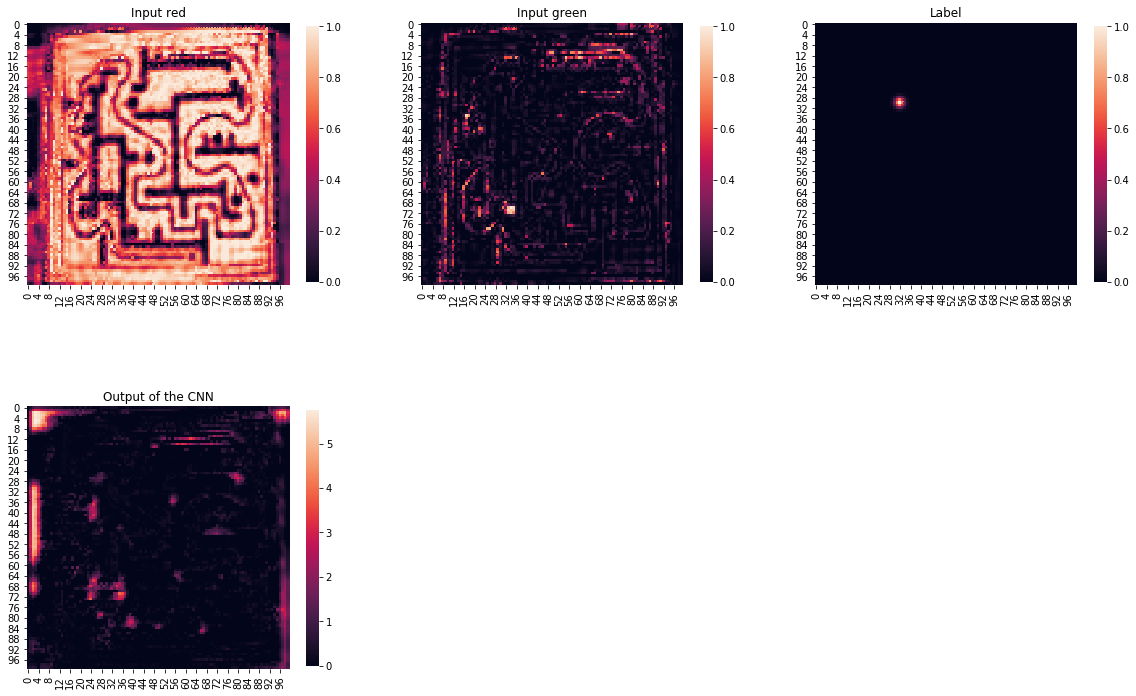

Training Loss: 20280.0605


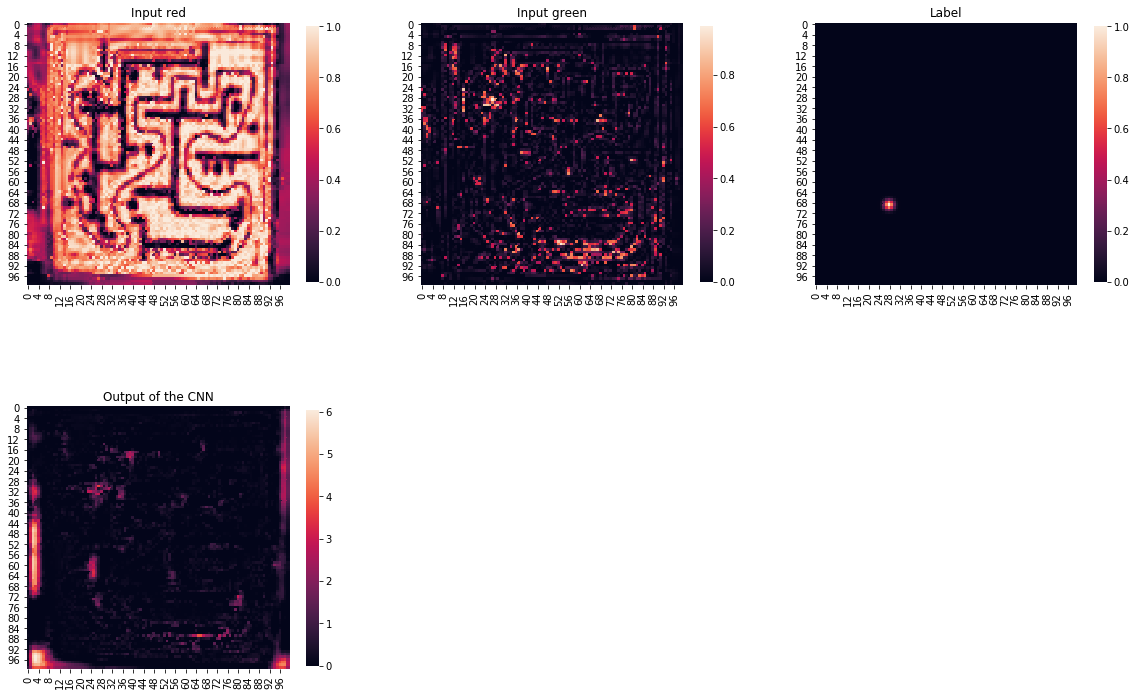

Training Loss: 19273.1406


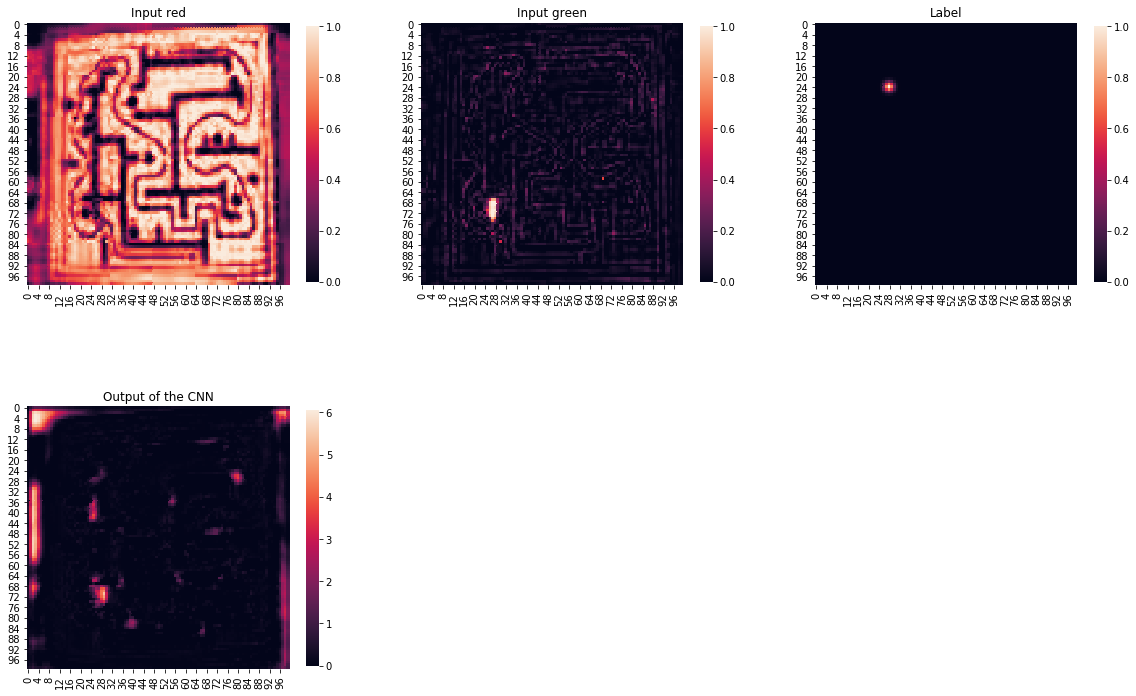

Training Loss: 18437.3984


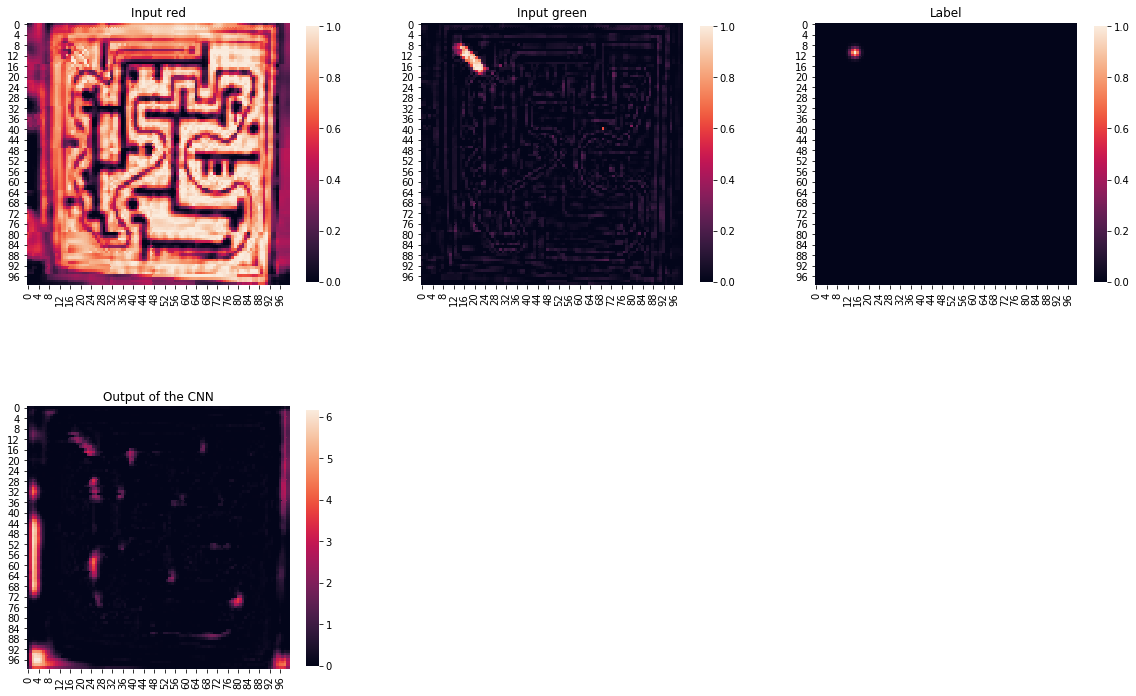

Training Loss: 18135.3477


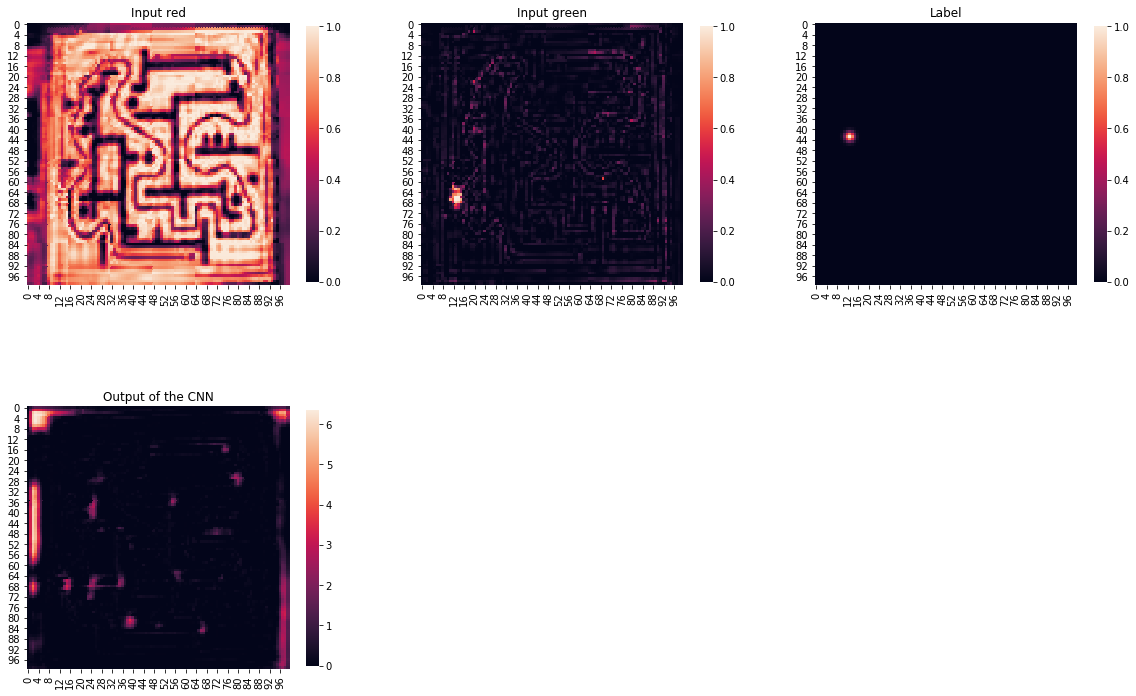

Training Loss: 18722.3203


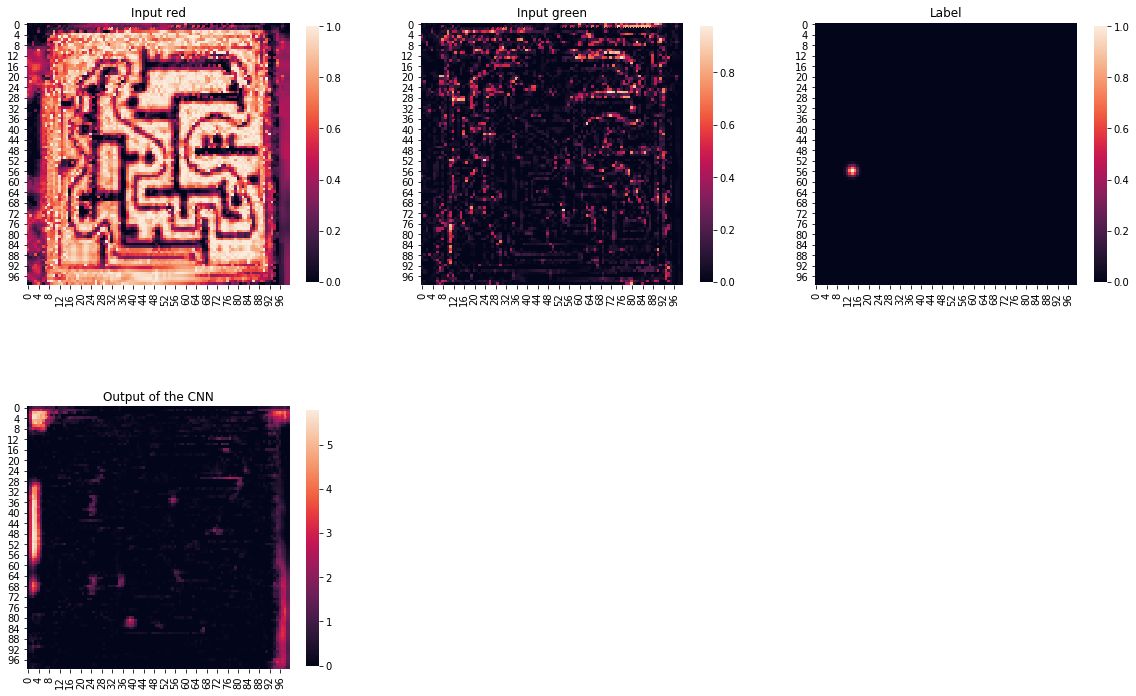

Training Loss: 17950.4883


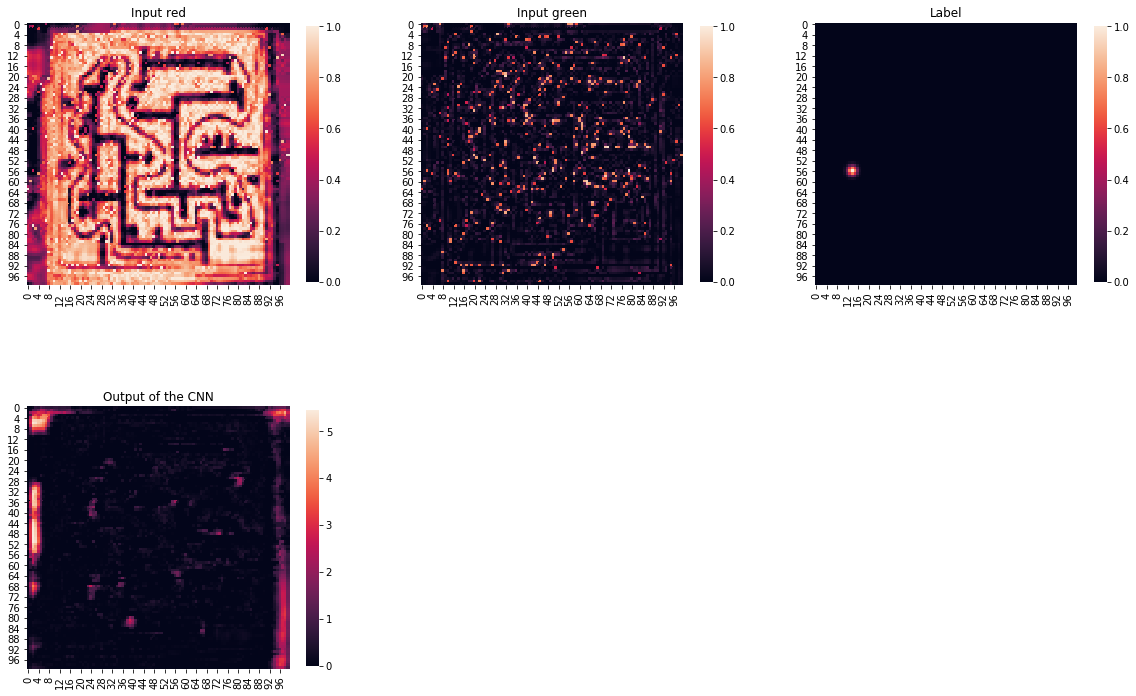

Training Loss: 17502.7129


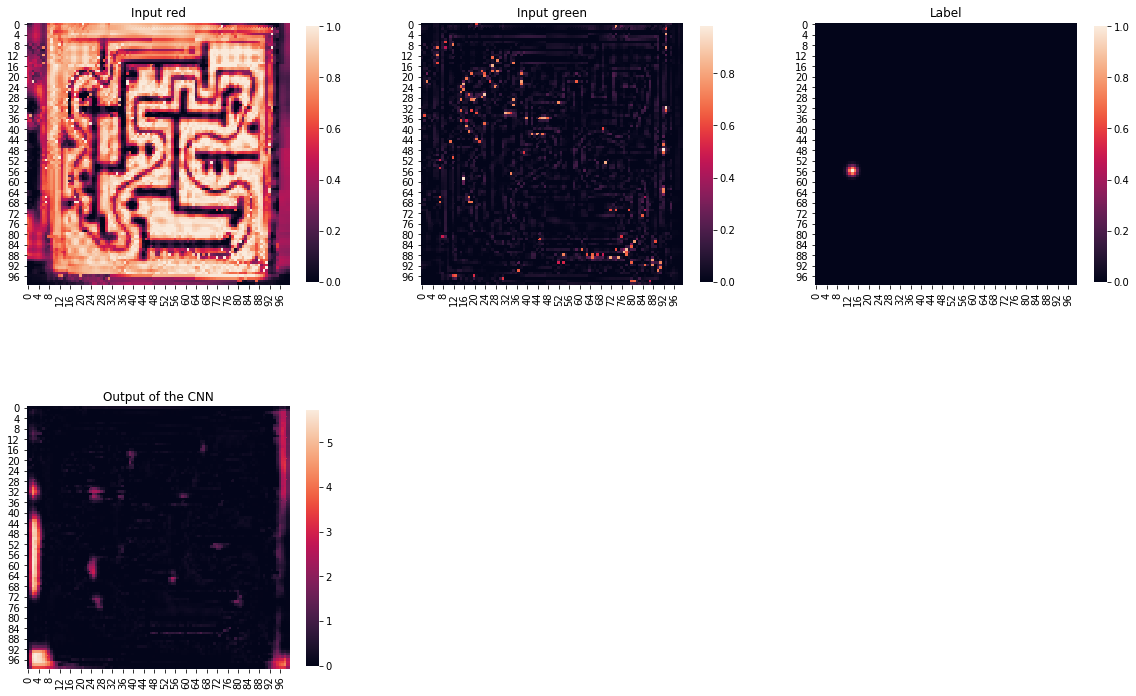

Training Loss: 17098.4375


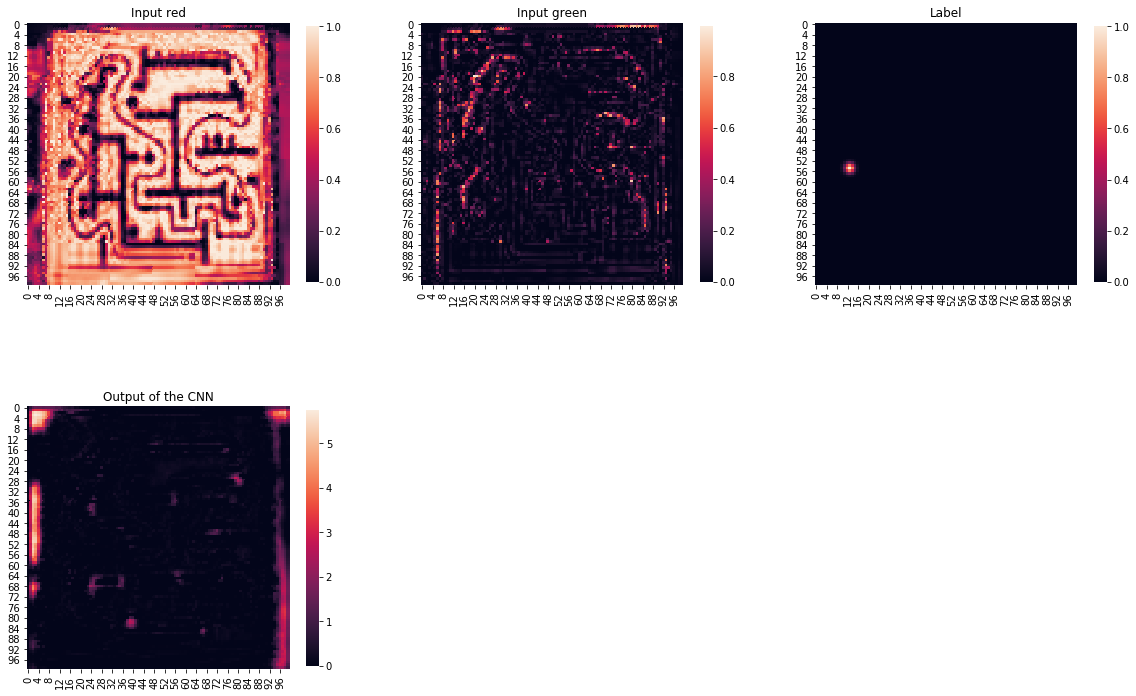

Training Loss: 16880.1445


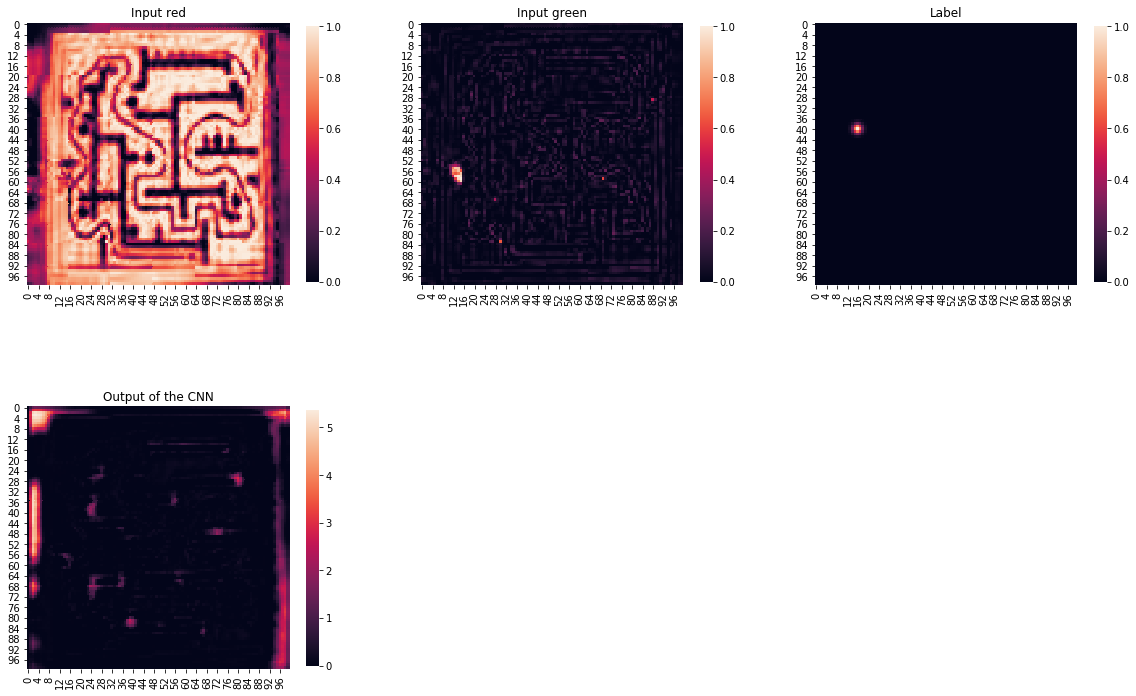

Training Loss: 16482.1562


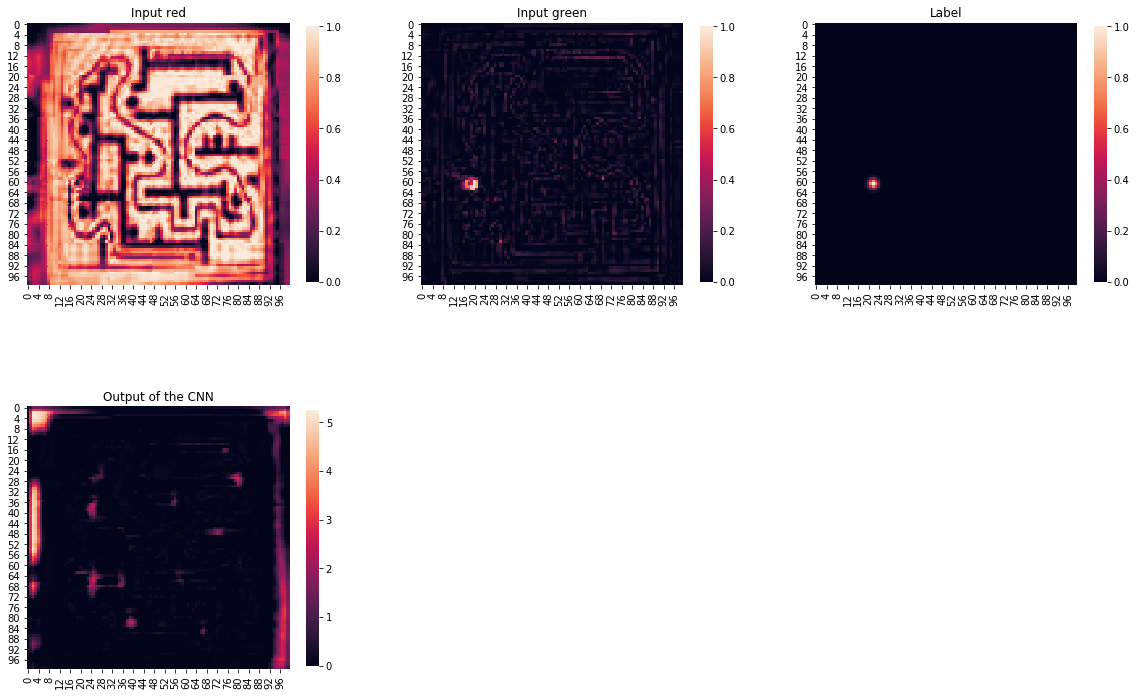

Training Loss: 16089.4512


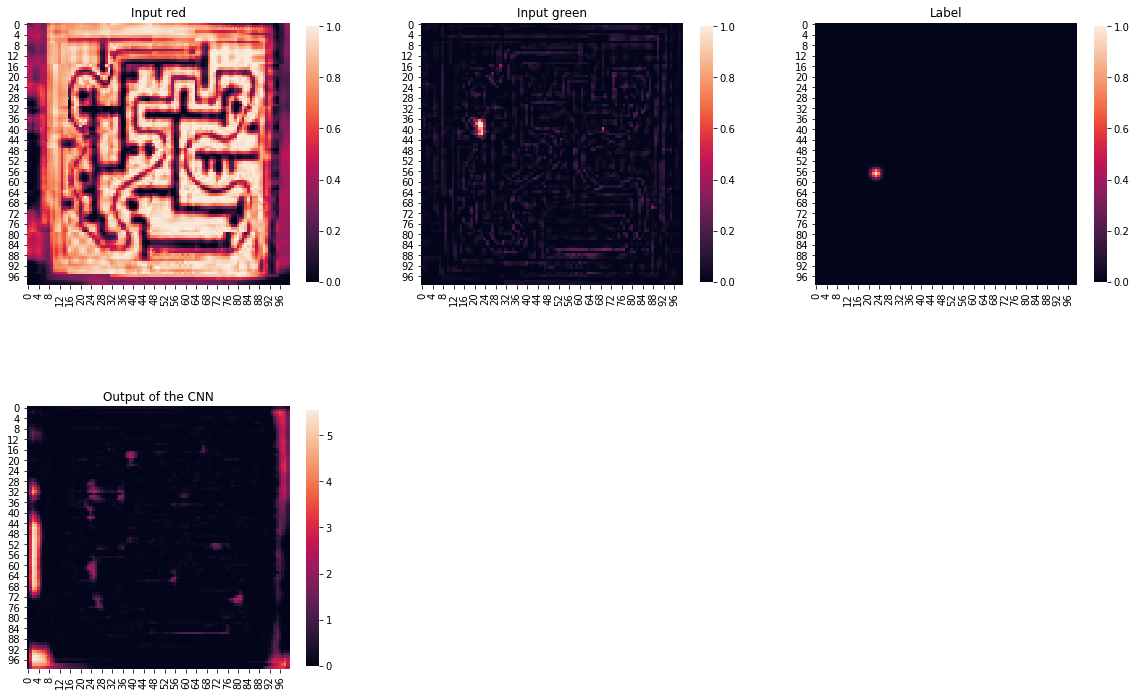

Training Loss: 15660.7031


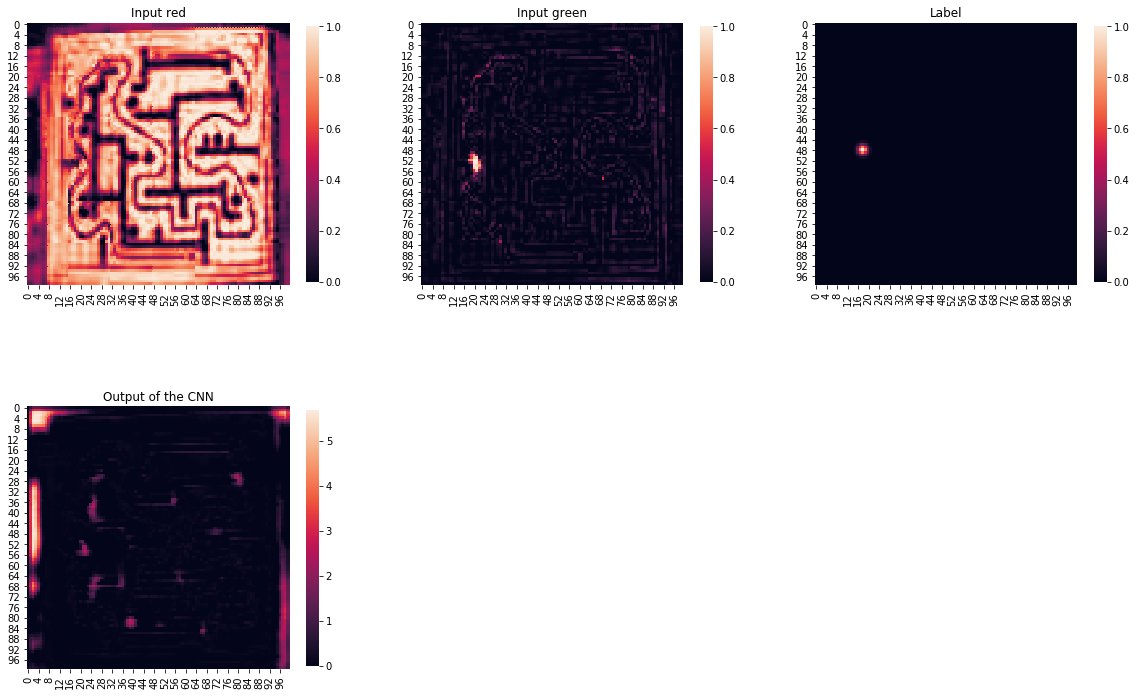

Training Loss: 15611.8594


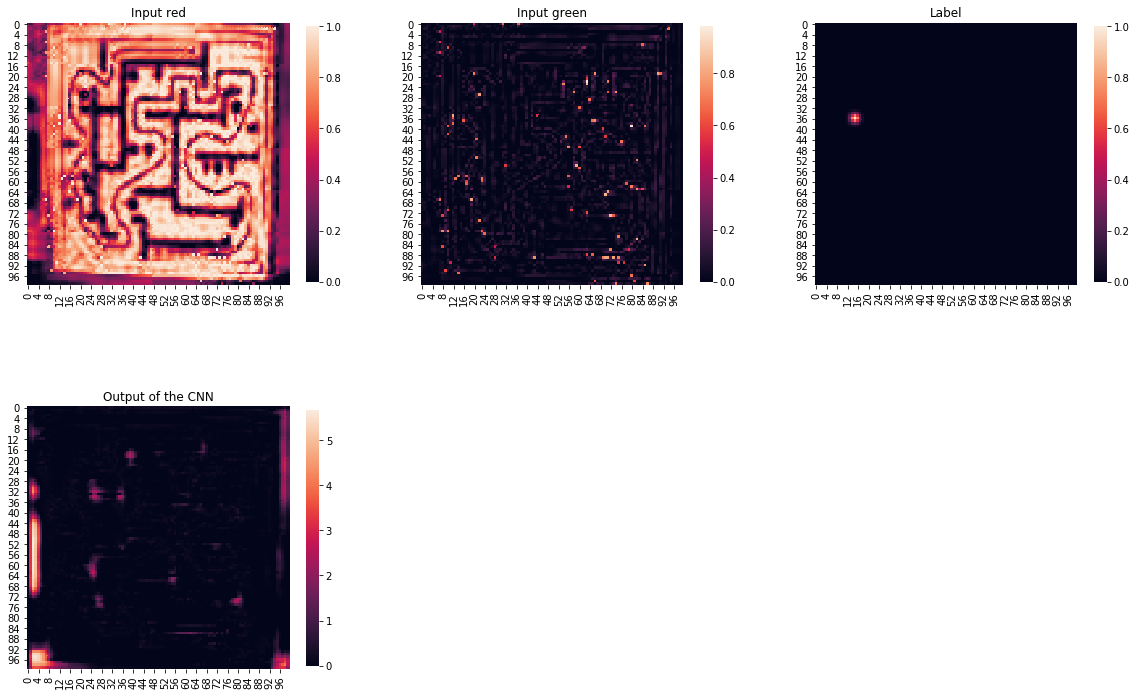

Training Loss: 15463.8945


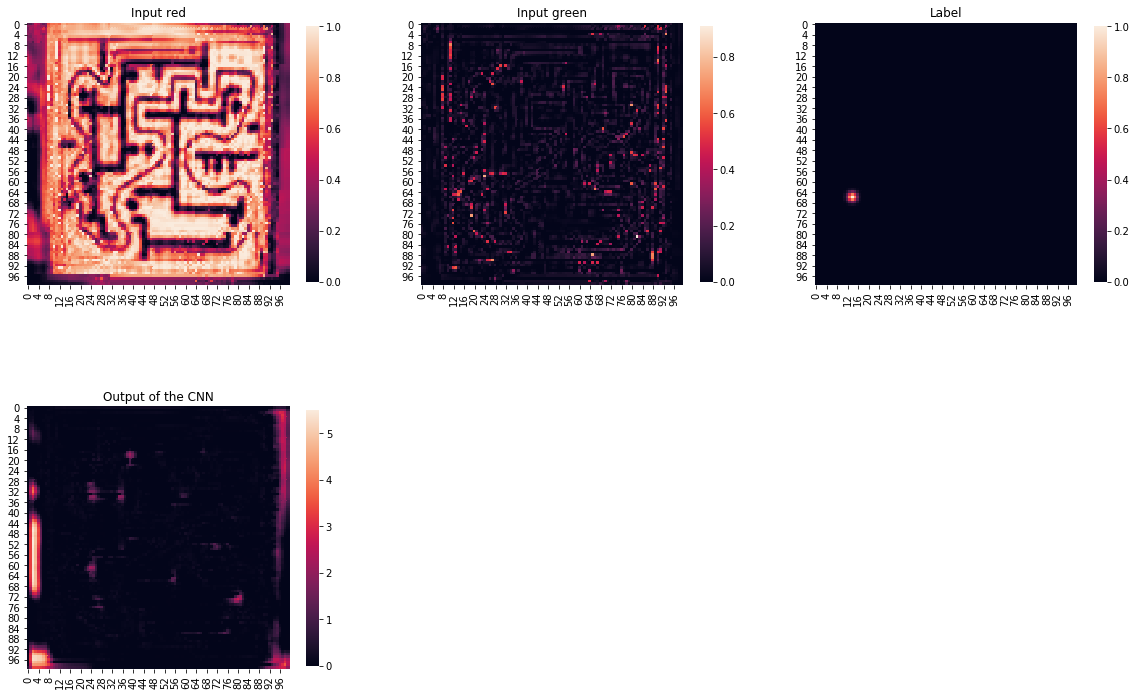

Training Loss: 15024.2617


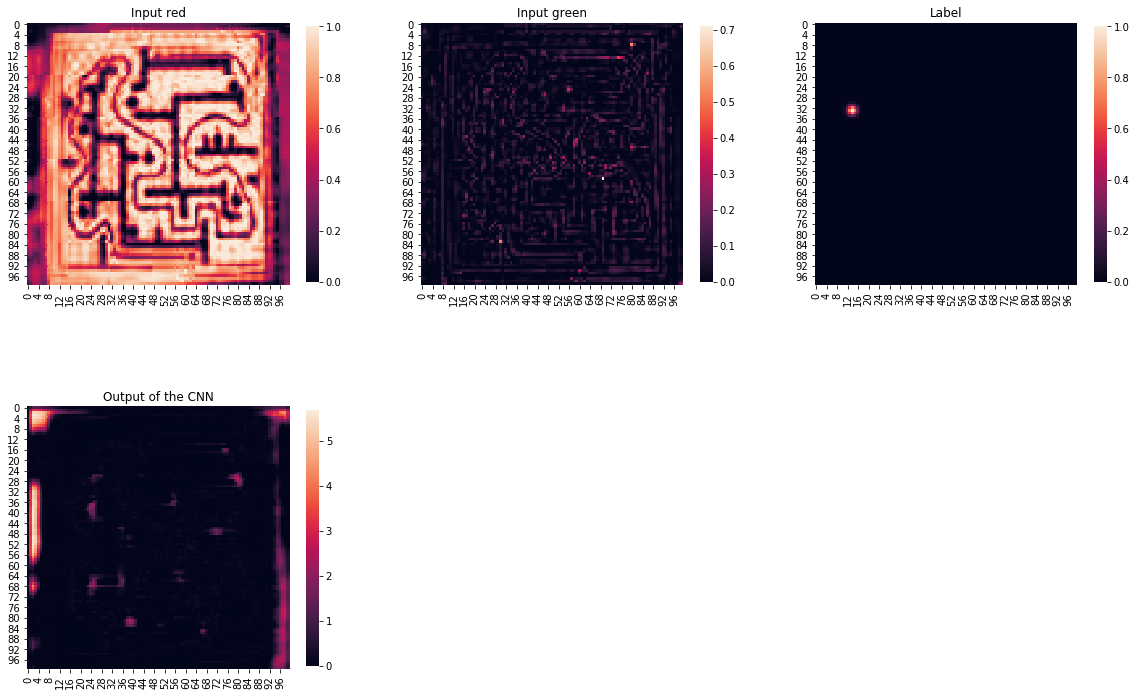

Training Loss: 14751.2676


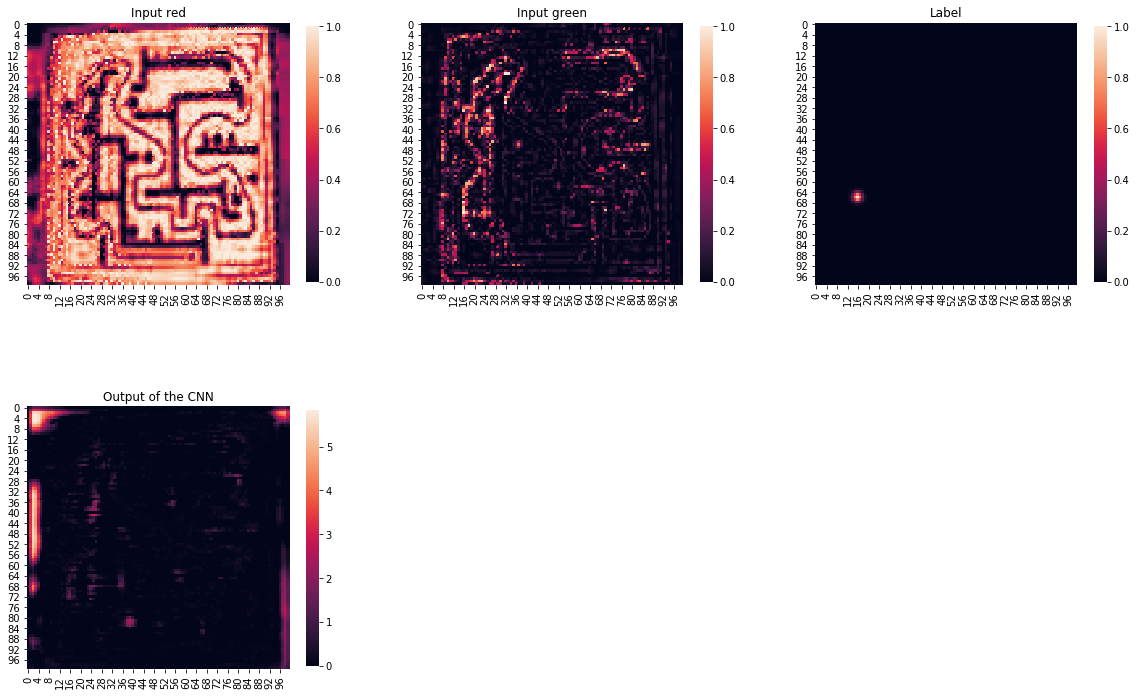

Training Loss: 14658.0469


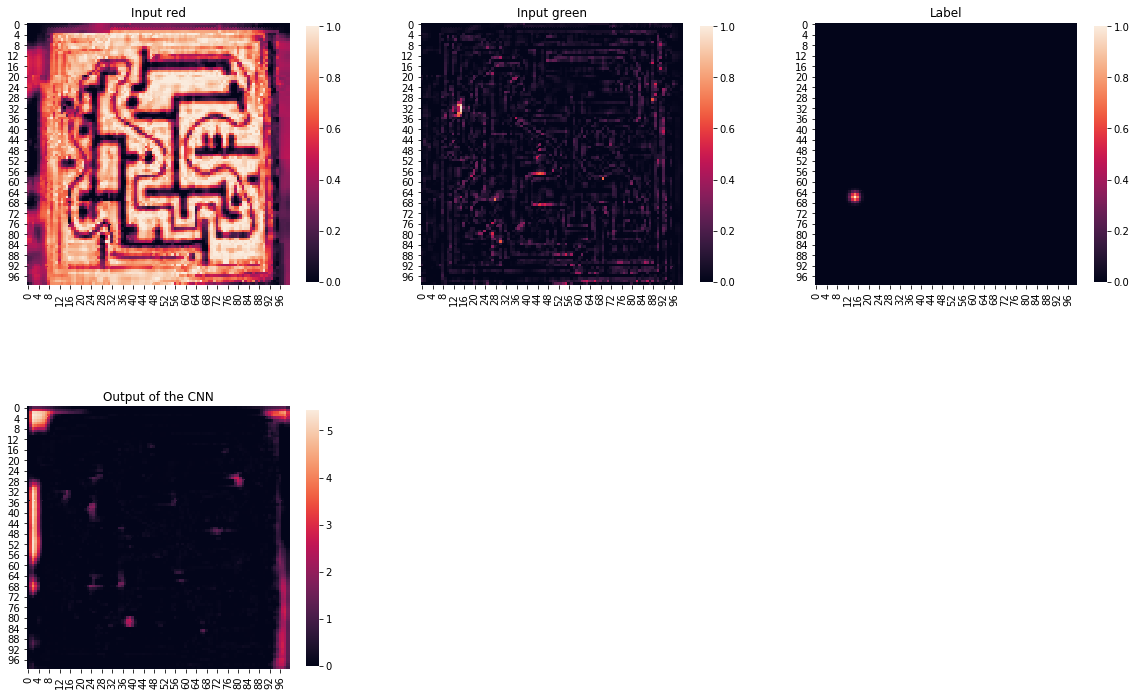

Training Loss: 14334.7822


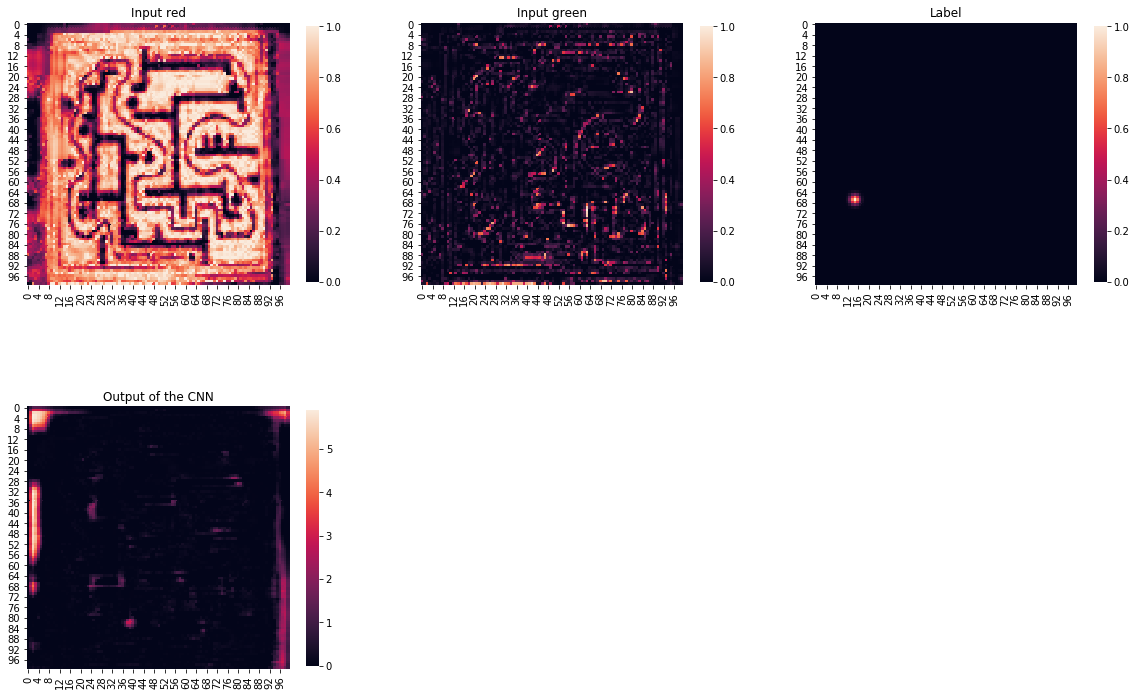

Training Loss: 14420.4277


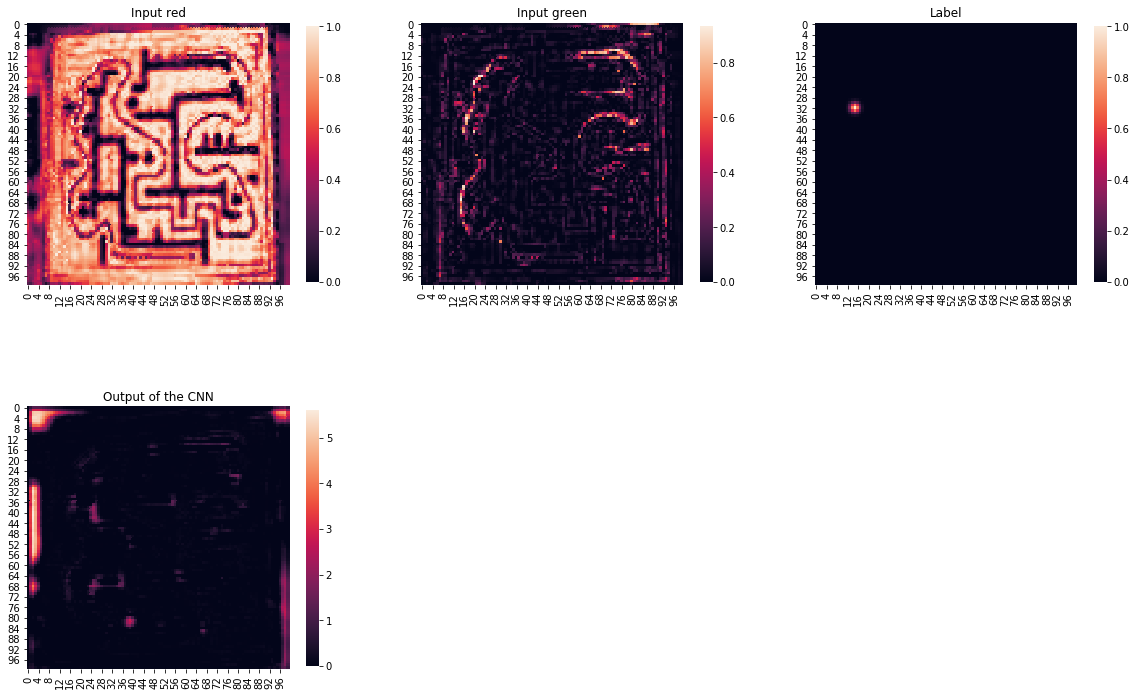

Training Loss: 13760.1953


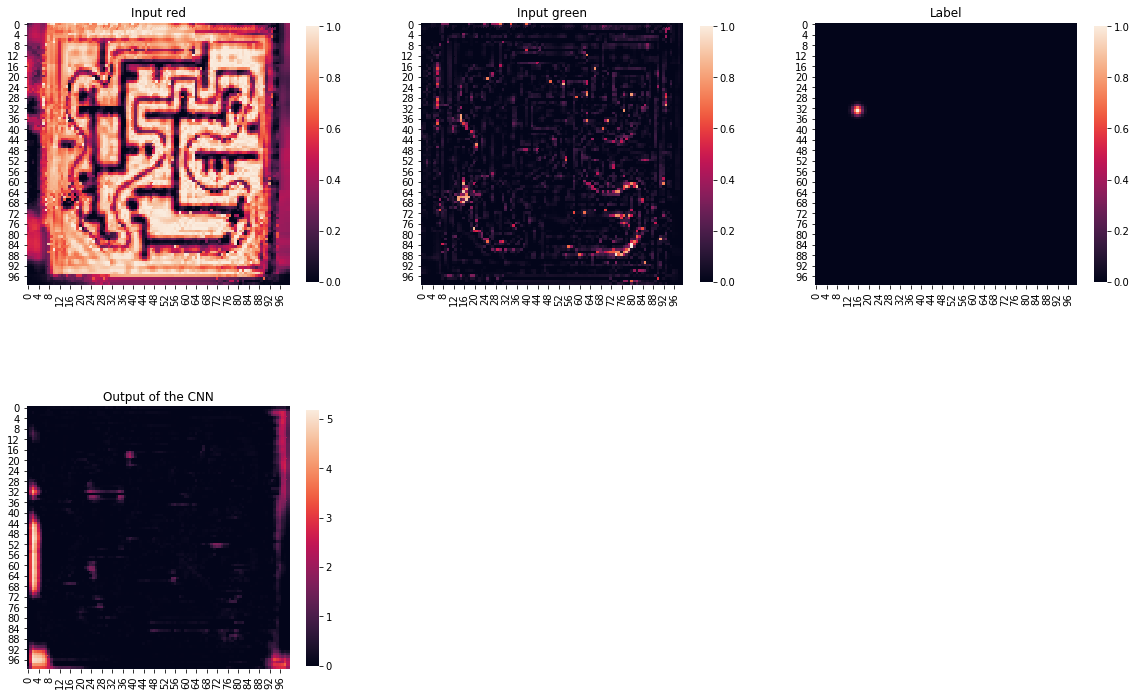

Training Loss: 13514.4062


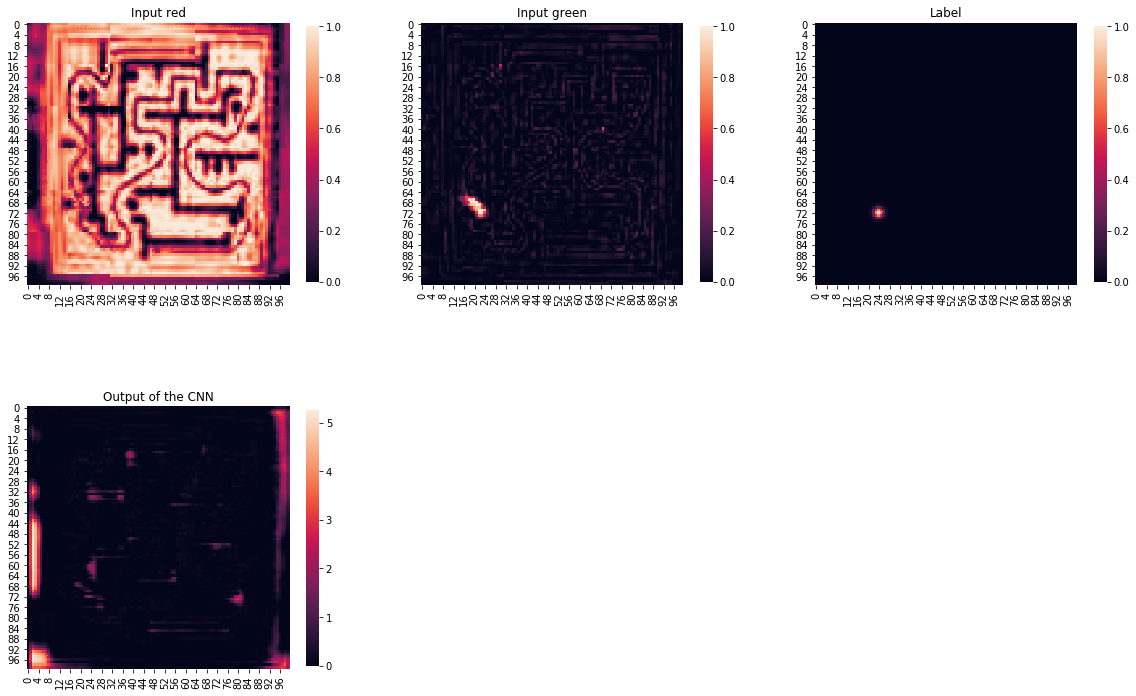

Training Loss: 13213.6484


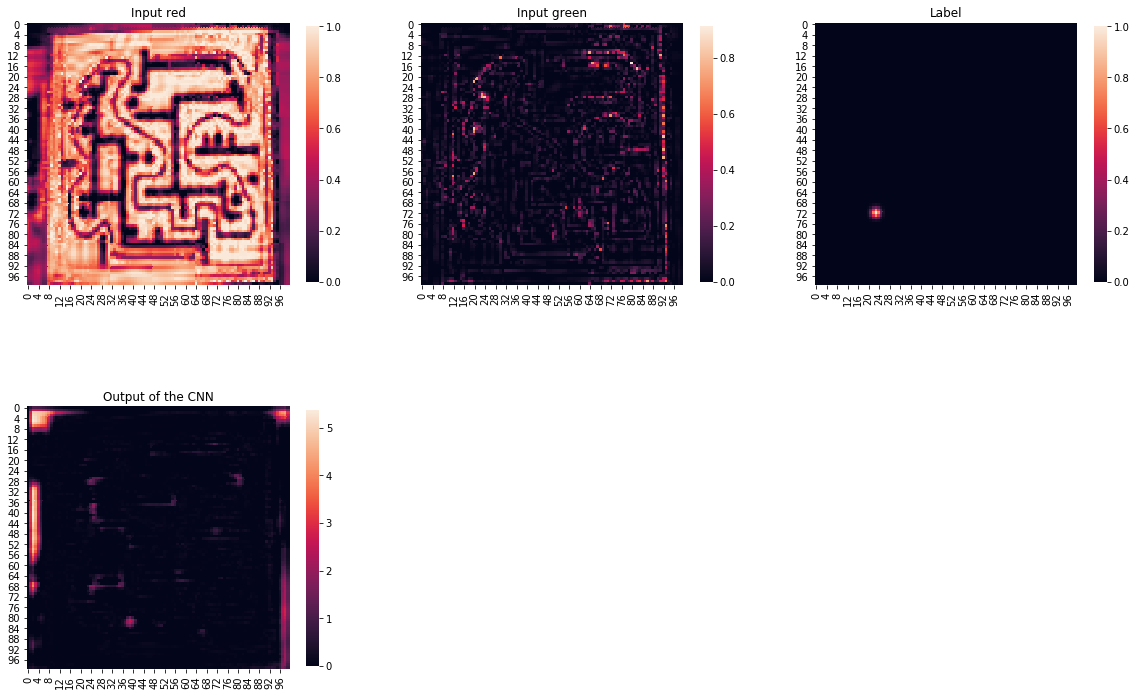

Training Loss: 12956.2871


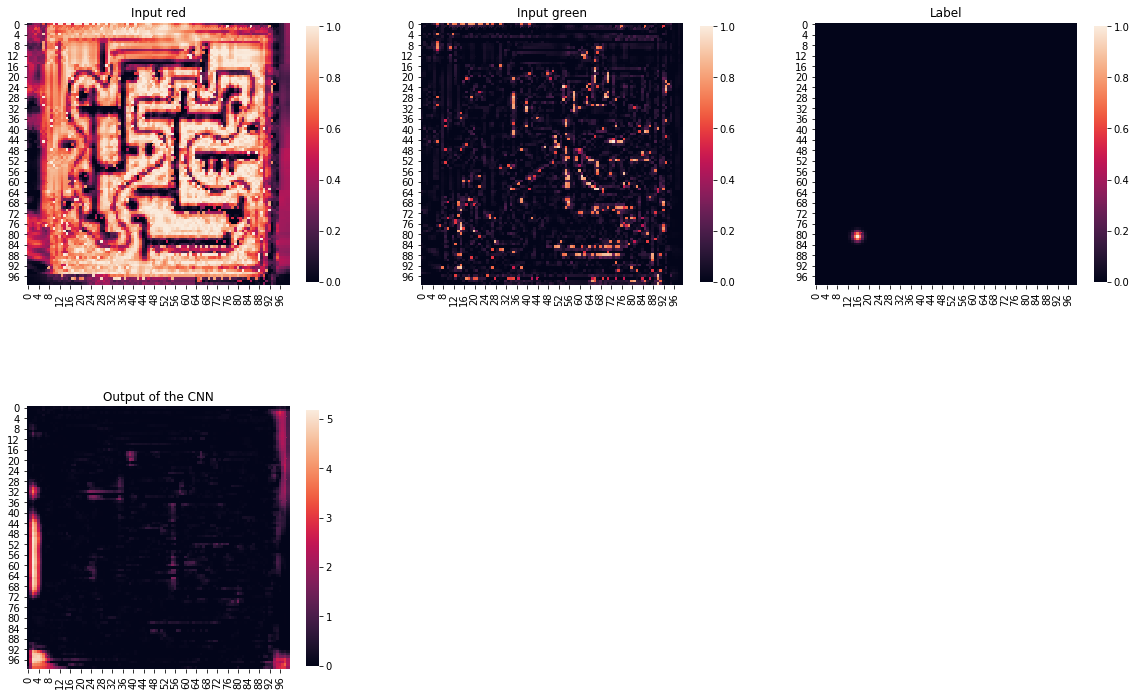

Training Loss: 13012.7256


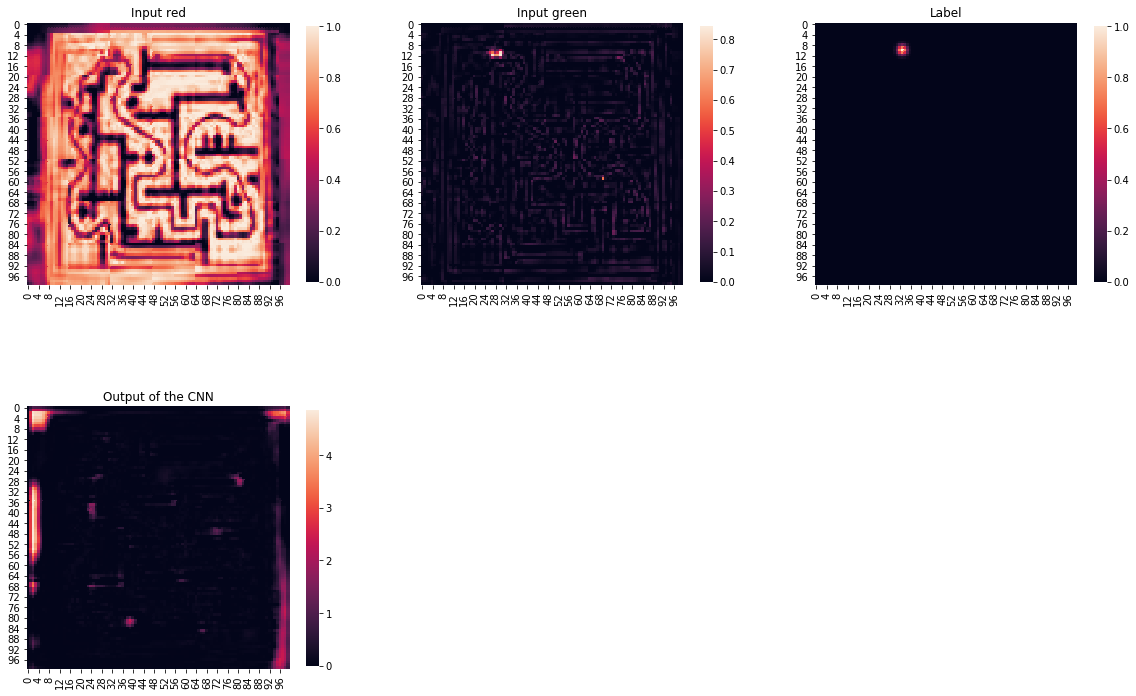

Training Loss: 12782.7686


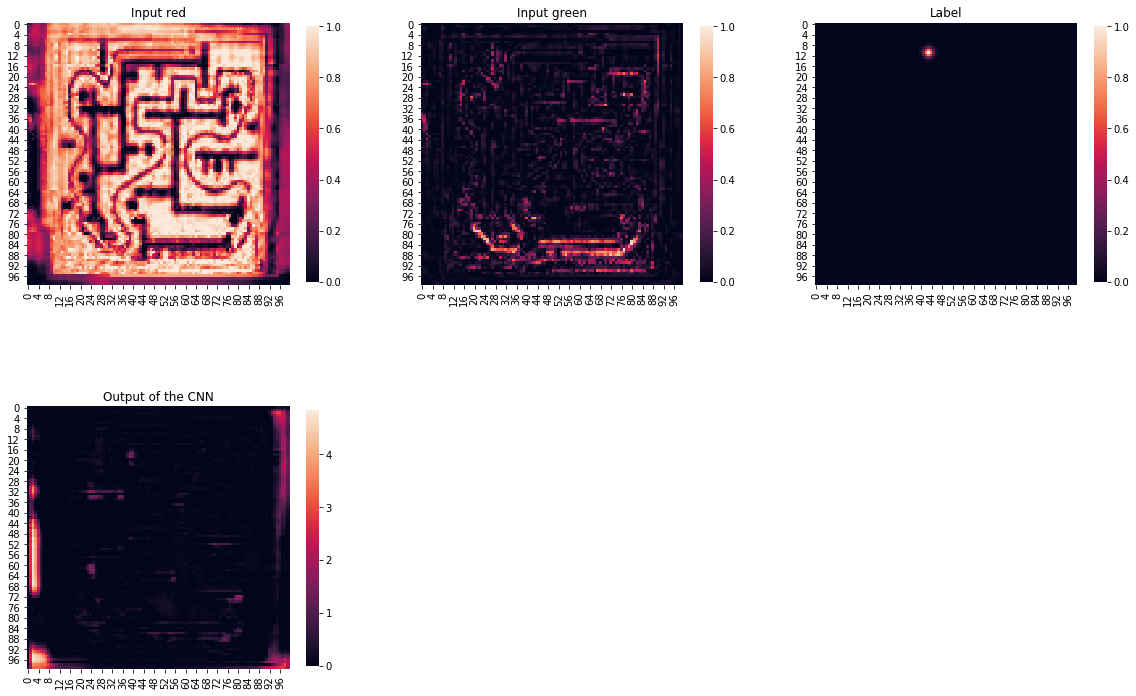

Training Loss: 12440.2686


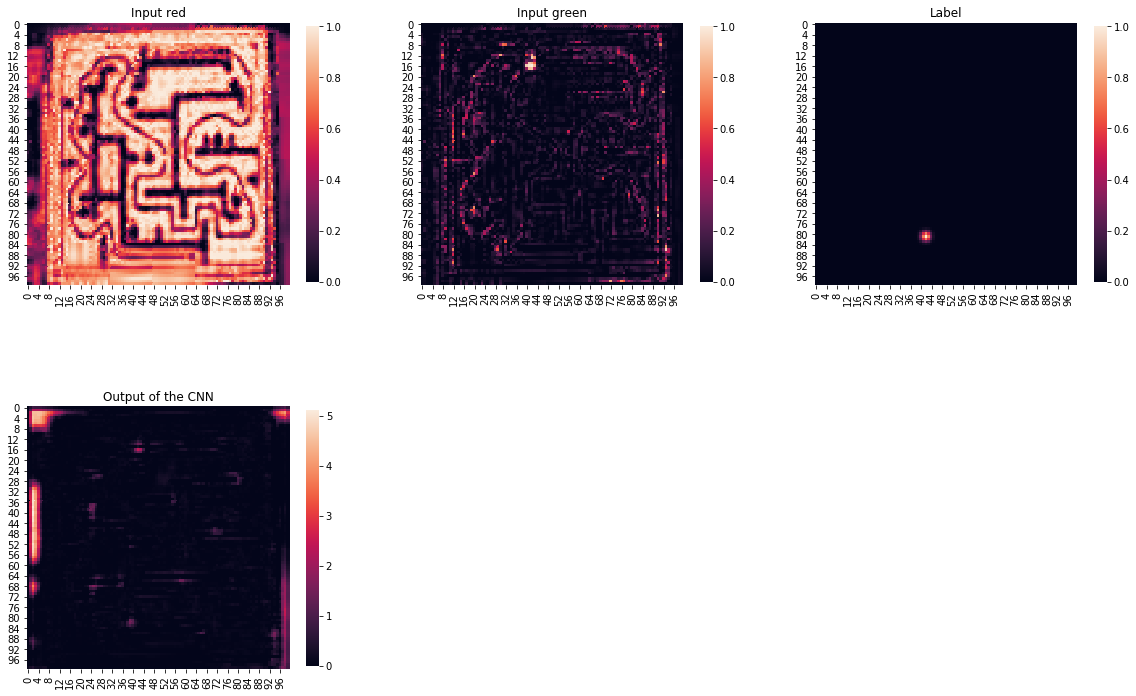

Training Loss: 12264.6641


KeyboardInterrupt: 

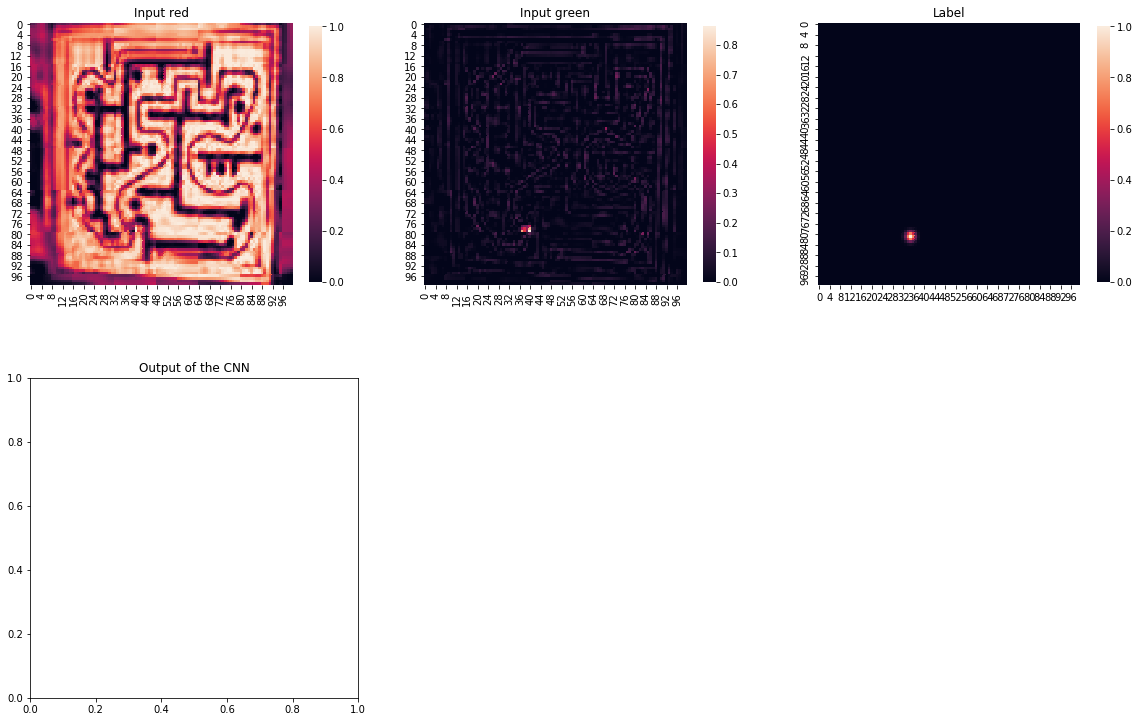

In [6]:
# Define the training loop with loss-function and optimizer

loss_fn = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 10
epochs_no_improve_limit = 11

train_losses = []
val_losses = []


def train():
    epochs_no_improve = 0
    min_val_loss = np.Inf
    since = time.time()
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        val_loss = 0
        
        for train_inputs, train_labels in dataloaders['train']:
            optimizer.zero_grad()
            output = net(train_inputs.to(device)).reshape(batch_size, 100, 100)
            loss = loss_fn(output.cpu(), train_labels.cpu().reshape(batch_size, 100, 100))
            
            fig = plt.figure(figsize = (20,20))
            ax1 = fig.add_subplot(3, 3, 1)
            ax1.set_title('Input red')
            ax2 = fig.add_subplot(3, 3, 2)
            ax2.set_title('Input green')
            ax3 = fig.add_subplot(3, 3, 3)
            ax3.set_title('Label')
            ax4 = fig.add_subplot(3, 3, 4)
            ax4.set_title('Output of the CNN')

            sns.heatmap(train_inputs[0][0], ax=ax1, square=True, cbar_kws={'shrink': .8})
            sns.heatmap(train_inputs[0][1], ax=ax2, square=True, cbar_kws={'shrink': .8})
            sns.heatmap(train_labels[0][0], ax=ax3, square=True, cbar_kws={'shrink': .8})
            sns.heatmap(output.cpu().detach().numpy()[0], ax=ax4, square=True, cbar_kws={'shrink': .8})
            plt.show()
            
            train_losses.append(float(loss))
            print('Training Loss: {:.4f}'.format(loss))
            loss.backward()
            optimizer.step()
        
        del train_inputs
        del train_labels
        del output
        del loss
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            for val_inputs, val_labels in dataloaders['val']:
                torch.cuda.empty_cache()
                output = net(val_inputs.to(device)).reshape(batch_size, 100, 100)
                loss = loss_fn(output.cpu(), val_labels.cpu().reshape(batch_size, 100, 100))
                val_loss += loss

            val_loss = val_loss / len(dataloaders['val'])
            val_losses.append(float(val_loss))
            print('-' * 10)
            print('Validation Loss: {:.4f}'.format(val_loss))

            if val_loss < min_val_loss:
                torch.save(net, 'Nets/pt-labi_CNN_minloss{:.4f}.pt'.format(min_val_loss))
                epochs_no_improve = 0
                min_val_loss = val_loss
            else:
                epochs_no_improve += 1
                if epochs_no_improve == epochs_no_improve_limit:
                    print('Early stopping initiated')
                    model = torch.load('Nets/pt-labi_CNN_minloss{:.4f}.pt'.format(min_val_loss))
                    print('Best model so far has been loaded')
    print('Least validation Loss: {:4f}'.format(min_val_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Finished training')
train()

In [ ]:
# Define the testing loop and output some heatmaps
# to estimate the performance of the CNN

def test():
    test_loss = 0
    with torch.no_grad():
        for test_inputs, test_labels in dataloaders['test']:
            output = net(test_inputs.to(device)).reshape(batch_size, 100, 100)
            loss = loss_fn(output.cpu(), test_labels.cpu())
            output = output[0].reshape(100, 100).cpu().detach().numpy()
            test_labels = test_labels[0].reshape(100, 100)
            test_loss += loss

            fig = plt.figure(figsize = (20,20))
            ax1 = fig.add_subplot(3, 3, 1)
            ax1.set_title('Output')
            ax2 = fig.add_subplot(3, 3, 2)
            ax2.set_title('Label')

            sns.heatmap(output, ax=ax1, square=True, cbar_kws={'shrink': .8})
            sns.heatmap(test_labels, ax=ax2, square=True, cbar_kws={'shrink': .8})
            plt.show()
        
        test_loss = test_loss/len(dataloaders['test'])
        print('Average test loss: ' ,test_loss.numpy())
        print('Testing completed')
test()